In [1]:
%load_ext autoreload
%autoreload 2

import os,sys,warnings
import h5py, pandas
import numpy as np
np.seterr(invalid=['ignore','warn'][0])
import math,cmath,pickle
from matplotlib.backends.backend_pdf import PdfPages
from scipy.optimize import curve_fit,fsolve
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('default')
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.titlesize'] = 20
mpl.rcParams['figure.figsize'] = [6.4*1.2,4.8*1.2]
mpl.rcParams['axes.labelsize'] = 30
mpl.rcParams['axes.titlesize'] = 30
mpl.rcParams['lines.marker'] = 's'
mpl.rcParams['lines.linestyle'] = ''
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['errorbar.capsize'] = 12
mpl.rcParams['xtick.labelsize'] = mpl.rcParams['ytick.labelsize'] = 22
mpl.rcParams['xtick.major.size'] = mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['xtick.top']=mpl.rcParams['ytick.right']=True
mpl.rcParams['xtick.direction']=mpl.rcParams['ytick.direction']='in'
mpl.rcParams['legend.fontsize'] = 24
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

# mpl.rcParams.update({"axes.grid" : True})
import util as yu
yu.flag_fast=False

hbarc = 1/197.3

enss=['a','b','c','d']
# enss=['a']
ens2full={'a24':'cA211.53.24','a':'cA2.09.48','b':'B64','c':'C80','d':'D96'}
ens2label={'a24':'A24','a':'A48','b':'B64','c':'C80','d':'D96'}
ens2a={'a24':0.0908,'a':0.0938,'b':0.07957,'c':0.06821,'d':0.05692} # fm
ens2N={'a24':24,'a':48,'b':64,'c':80,'d':96}
ens2N_T={'a24':24*2,'a':48*2,'b':64*2,'c':80*2,'d':96*2}

ens2mN={'a':931,'b':946.4,'c':943.6,'d':941.4}
ens2amN={ens:ens2mN[ens]*ens2a[ens]*hbarc for ens in enss}
ens2mpi={'a':131,'b':140.2,'c':136.7,'d':140.8}
ens2ampi={ens:ens2mpi[ens]*ens2a[ens]*hbarc for ens in enss}
ens2mpiOS={'a':251,'b':297.5,'c':248.9,'d':210.0}
ens2ampiOS={ens:ens2mpiOS[ens]*ens2a[ens]*hbarc for ens in enss}
ens2mpi0={'a':115.7,'b':140.2,'c':136.7,'d':140.8}
ens2ampi0={ens:ens2mpi0[ens]*ens2a[ens]*hbarc for ens in enss}


ens2ZA={'a':0.791,'b':0.74294,'c':0.75830,'d':0.77395}
ens2ZSbyZP={'a':0.661/0.500,'b':0.79018,'c':0.82308,'d':0.85095}
ens2ZP={'a24':0.4670,'a':0.500,'b':0.4746,'c':0.4771,'d':0.4871}

ens2amu={'a24':0.0053,'a':0.0009,'b':0.00072,'c':0.0006,'d':0.00054}

ens2aInv={ens:1/(ens2a[ens]*hbarc) for ens in enss} # MeV

def fsolve2(func,x0):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        res=fsolve(func, x0)[0]
    return res if res!=x0 else np.NaN


In [2]:
datas={}
for ens in enss:
    t={'a':'cA2.09.48','b':'B72.64_6','c':'C60.80_6','d':'D54.96_6'}[ens]
    path=f'/capstor/store/cscs/userlab/s1174/lyan/code/projectData/NST_f/data_subtractionMethod/{t}.pkl'
    datas[ens]=pickle.load(open(path,'rb'))

# data=datas['d']
# print(data['twop3_mom1'].keys())
# print(data['twop3_mom1']['12'].shape)

In [3]:
fig, axs = yu.getFigAxs(len(enss),2,sharex=True,sharey=True)
yu.addRowHeader(axs,[ens2label[ens] for ens in enss],fontsize=20)
yu.addColHeader(axs,['conn','full'],fontsize=20)

t_cut=2

yu.jackknife=lambda x:x

for iens,ens in enumerate(enss):
    irow=iens
    xunit=ens2a[ens]; yunit=ens2ZA[ens]
    data=datas[ens]    
    
    amN=ens2amN[ens]; ampi=ens2ampi[ens]
    ap1=2*math.pi/ens2N[ens]
    aEN=np.sqrt(amN**2+ap1**2)
    aDEN=aEN-amN
    aEpi=np.sqrt(ampi**2+ap1**2)
    kappa=np.sqrt(2*amN**2/(aEN*(aEN+amN)))
    
    c2pta=yu.jackknife(data['twop_mom0'])
    c2ptb=yu.jackknife(data['twop_mom1'])
    
    tfs=[int(tf[2:]) for tf in data['G0_mom1'].keys()]
    
    for tf in tfs:
        c3pt_AP=(yu.jackknife(data['GA_mom1_momi1'][f'dt{tf}']-data['GA_mom1_momi0'][f'dt{tf}']))
        c3pt_0=yu.jackknife(data['G0_mom1'][f'dt{tf}'])/(2*math.pi/ens2N[ens])
        
        c3pt_dAP=c3pt_AP-np.roll(c3pt_AP,1,axis=1)
        c3pt_d0=c3pt_0-np.roll(c3pt_0,1,axis=1)
        c3pt_DeltaP=(aDEN/(ap1**2) * c3pt_dAP - c3pt_d0)/(aDEN**2-aEpi**2)
        
        ax=axs[irow,0]
        c3pt=c3pt_AP / (-kappa*ap1**2/(2*amN**2))
        ratio=c3pt/np.sqrt(c2pta[:,tf:tf+1]*c2ptb[:,tf:tf+1]) *\
            np.sqrt(c2pta[:,:tf+1]/c2pta[:,:tf+1][:,::-1]*c2ptb[:,:tf+1][:,::-1]/c2ptb[:,:tf+1])
        
        mean,err=yu.jackme(ratio)
        plt_x=np.arange(t_cut - tf//2,tf//2 - (t_cut-1))*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
        ax.errorbar(plt_x,plt_y,plt_yerr,mfc='white')  
        
        ax=axs[irow,0]
        c3pt=(c3pt_AP + ap1**2 * c3pt_DeltaP ) / (-kappa*ap1**2/(2*amN**2)) 
        ratio=c3pt/np.sqrt(c2pta[:,tf:tf+1]*c2ptb[:,tf:tf+1]) *\
            np.sqrt(c2pta[:,:tf+1]/c2pta[:,:tf+1][:,::-1]*c2ptb[:,:tf+1][:,::-1]/c2ptb[:,:tf+1])
            
        mean,err=yu.jackme(ratio)
        plt_x=np.arange(t_cut - tf//2,tf//2 - (t_cut-1))*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
        ax.errorbar(plt_x,plt_y,plt_yerr)  
    
    if 'GA_mom1_momi1_disc' in data:
        for tf in tfs:
            c3pt_AP=(yu.jackknife(data['GA_mom1_momi1'][f'dt{tf}']-data['GA_mom1_momi0'][f'dt{tf}'])) + (yu.jackknife(data['GA_mom1_momi1_disc'][f'dt{tf}']-data['GA_mom1_momi0_disc'][f'dt{tf}']))
            c3pt_0=yu.jackknife(data['G0_mom1'][f'dt{tf}'])/(2*math.pi/ens2N[ens]) + yu.jackknife(data['G0_mom1_disc'][f'dt{tf}'])/(2*math.pi/ens2N[ens])
            
            c3pt_dAP=c3pt_AP-np.roll(c3pt_AP,1,axis=1)
            c3pt_d0=c3pt_0-np.roll(c3pt_0,1,axis=1)
            c3pt_DeltaP=(aDEN/(ap1**2) * c3pt_dAP - c3pt_d0)/(aDEN**2-aEpi**2)
            
            ax=axs[irow,1]
            c3pt=c3pt_AP / (-kappa*ap1**2/(2*amN**2)) 
            ratio=c3pt/np.sqrt(c2pta[:,tf:tf+1]*c2ptb[:,tf:tf+1]) *\
                np.sqrt(c2pta[:,:tf+1]/c2pta[:,:tf+1][:,::-1]*c2ptb[:,:tf+1][:,::-1]/c2ptb[:,:tf+1])
            
            mean,err=yu.jackme(ratio)
            plt_x=np.arange(t_cut - tf//2,tf//2 - (t_cut-1))*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
            ax.errorbar(plt_x,plt_y,plt_yerr,mfc='white')  
            
            ax=axs[irow,1]
            c3pt=(c3pt_AP + ap1**2 * c3pt_DeltaP ) / (-kappa*ap1**2/(2*amN**2)) 
            ratio=c3pt/np.sqrt(c2pta[:,tf:tf+1]*c2ptb[:,tf:tf+1]) *\
                np.sqrt(c2pta[:,:tf+1]/c2pta[:,:tf+1][:,::-1]*c2ptb[:,:tf+1][:,::-1]/c2ptb[:,:tf+1])
                
            mean,err=yu.jackme(ratio)
            plt_x=np.arange(t_cut - tf//2,tf//2 - (t_cut-1))*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
            ax.errorbar(plt_x,plt_y,plt_yerr)  

plt.tight_layout()
plt.savefig(f'fig/GP.pdf')
plt.close()   

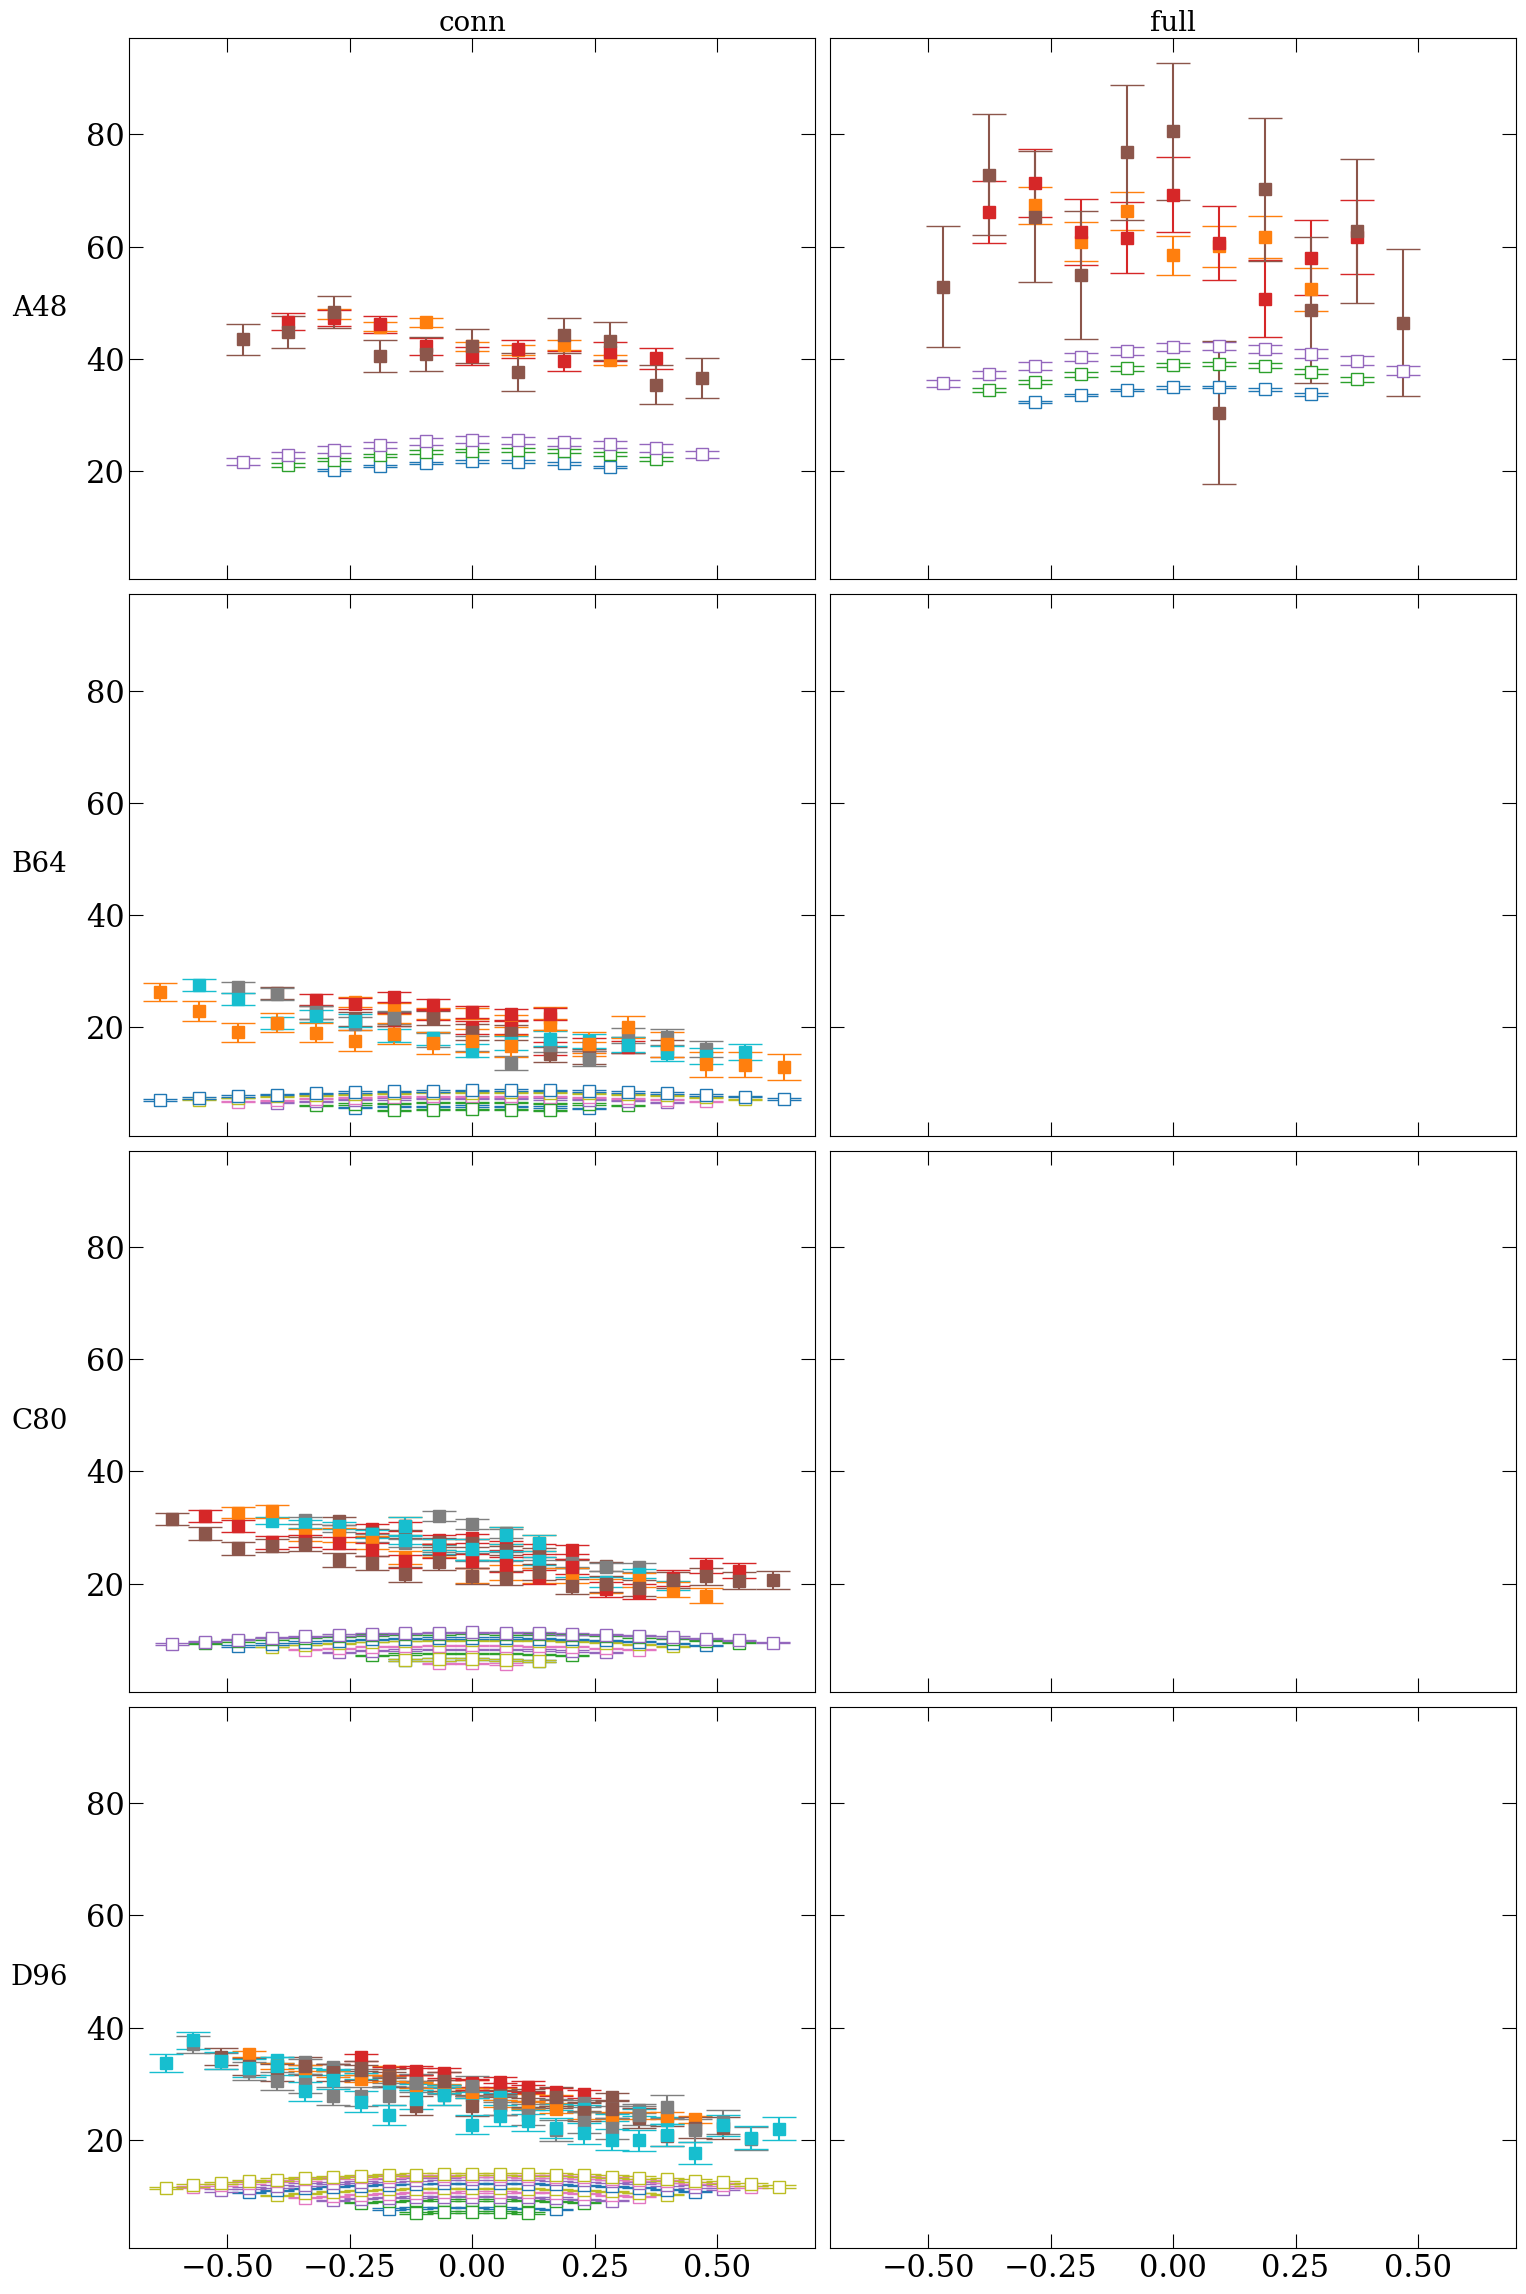

In [15]:
fig, axs = yu.getFigAxs(len(enss),2,sharex=True,sharey=True)
yu.addRowHeader(axs,[ens2label[ens] for ens in enss],fontsize=20)
yu.addColHeader(axs,['conn','full'],fontsize=20)

t_cut=2

yu.jackknife=lambda x:x

for iens,ens in enumerate(enss):
    irow=iens
    xunit=ens2a[ens]; yunit= ens2ZSbyZP[ens] * ens2ZP[ens] 
    data=datas[ens]    
    
    amN=ens2amN[ens]; ampi=ens2ampi[ens]
    ap1=2*math.pi/ens2N[ens]
    aEN=np.sqrt(amN**2+ap1**2)
    aDEN=aEN-amN
    aEpi=np.sqrt(ampi**2+ap1**2)
    kappa=np.sqrt(2*amN**2/(aEN*(aEN+amN)))
    
    c2pta=yu.jackknife(data['twop_mom0'])
    c2ptb=yu.jackknife(data['twop_mom1'])
    
    tfs=[int(tf[2:]) for tf in data['G0_mom1'].keys()]
    
    for tf in tfs:
        c3pt_5=yu.jackknife(data['G5_mom1'][f'dt{tf}'])/(2*math.pi/ens2N[ens])
        c3pt_AP=(yu.jackknife(data['GA_mom1_momi1'][f'dt{tf}']-data['GA_mom1_momi0'][f'dt{tf}']))
        c3pt_0=yu.jackknife(data['G0_mom1'][f'dt{tf}'])/(2*math.pi/ens2N[ens])
        
        c3pt_dAP=c3pt_AP-np.roll(c3pt_AP,1,axis=1)
        c3pt_d0=c3pt_0-np.roll(c3pt_0,1,axis=1)
        c3pt_DeltaP=(aDEN/(ap1**2) * c3pt_dAP - c3pt_d0)/(aDEN**2-aEpi**2)
        c3pt_DeltaM=-(aEpi/(ap1**2) * c3pt_dAP + aDEN/aEpi * c3pt_d0)/(aDEN**2-aEpi**2)
        c3pt_Delta5=(ampi**2 * c3pt_DeltaP +  aEpi*aDEN * c3pt_DeltaM)/2 / (ens2amu[ens]/ap1) *ens2ZA[ens]/ens2ZSbyZP[ens]
        
        ax=axs[irow,0]
        c3pt=c3pt_5 / (-kappa/(1*amN))
        ratio=c3pt/np.sqrt(c2pta[:,tf:tf+1]*c2ptb[:,tf:tf+1]) *\
            np.sqrt(c2pta[:,:tf+1]/c2pta[:,:tf+1][:,::-1]*c2ptb[:,:tf+1][:,::-1]/c2ptb[:,:tf+1])
        
        mean,err=yu.jackme(ratio)
        plt_x=np.arange(t_cut - tf//2,tf//2 - (t_cut-1))*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
        ax.errorbar(plt_x,plt_y,plt_yerr,mfc='white')  
        
        ax=axs[irow,0]
        c3pt=(c3pt_5 + c3pt_Delta5/ap1) / (-kappa/amN)
        ratio=c3pt/np.sqrt(c2pta[:,tf:tf+1]*c2ptb[:,tf:tf+1]) *\
            np.sqrt(c2pta[:,:tf+1]/c2pta[:,:tf+1][:,::-1]*c2ptb[:,:tf+1][:,::-1]/c2ptb[:,:tf+1])
            
        mean,err=yu.jackme(ratio)
        plt_x=np.arange(t_cut - tf//2,tf//2 - (t_cut-1))*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
        ax.errorbar(plt_x,plt_y,plt_yerr)  
    
    if 'G5_mom1_disc' in data:
        for tf in tfs:
            c3pt_5=yu.jackknife(data['G5_mom1'][f'dt{tf}'])/(2*math.pi/ens2N[ens]) + yu.jackknife(data['G5_mom1_disc'][f'dt{tf}'])/(2*math.pi/ens2N[ens])
            c3pt_AP=(yu.jackknife(data['GA_mom1_momi1'][f'dt{tf}']-data['GA_mom1_momi0'][f'dt{tf}'])) + (yu.jackknife(data['GA_mom1_momi1_disc'][f'dt{tf}']-data['GA_mom1_momi0_disc'][f'dt{tf}']))
            c3pt_0=yu.jackknife(data['G0_mom1'][f'dt{tf}'])/(2*math.pi/ens2N[ens]) + yu.jackknife(data['G0_mom1_disc'][f'dt{tf}'])/(2*math.pi/ens2N[ens])
            
            c3pt_dAP=c3pt_AP-np.roll(c3pt_AP,1,axis=1)
            c3pt_d0=c3pt_0-np.roll(c3pt_0,1,axis=1)
            c3pt_DeltaP=(aDEN/(ap1**2) * c3pt_dAP - c3pt_d0)/(aDEN**2-aEpi**2)
            c3pt_DeltaM=-(aEpi/(ap1**2) * c3pt_dAP + aDEN/aEpi * c3pt_d0)/(aDEN**2-aEpi**2)
            c3pt_Delta5=(ampi**2 * c3pt_DeltaP +  aEpi*aDEN * c3pt_DeltaM)/2 / (ens2amu[ens]/ap1) *ens2ZA[ens]/ens2ZSbyZP[ens]
            
            ax=axs[irow,1]
            c3pt=c3pt_5 / (-kappa/(1*amN))
            ratio=c3pt/np.sqrt(c2pta[:,tf:tf+1]*c2ptb[:,tf:tf+1]) *\
                np.sqrt(c2pta[:,:tf+1]/c2pta[:,:tf+1][:,::-1]*c2ptb[:,:tf+1][:,::-1]/c2ptb[:,:tf+1])
            
            mean,err=yu.jackme(ratio)
            plt_x=np.arange(t_cut - tf//2,tf//2 - (t_cut-1))*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
            ax.errorbar(plt_x,plt_y,plt_yerr,mfc='white')  
            
            ax=axs[irow,1]
            c3pt=(c3pt_5 + c3pt_Delta5/ap1 ) / (-kappa/amN)
            ratio=c3pt/np.sqrt(c2pta[:,tf:tf+1]*c2ptb[:,tf:tf+1]) *\
                np.sqrt(c2pta[:,:tf+1]/c2pta[:,:tf+1][:,::-1]*c2ptb[:,:tf+1][:,::-1]/c2ptb[:,:tf+1])
                
            mean,err=yu.jackme(ratio)
            plt_x=np.arange(t_cut - tf//2,tf//2 - (t_cut-1))*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
            ax.errorbar(plt_x,plt_y,plt_yerr)  

# axs[0,0].set_ylim([0,80])

plt.tight_layout()
plt.savefig(f'fig/G5.pdf')
# plt.close()   

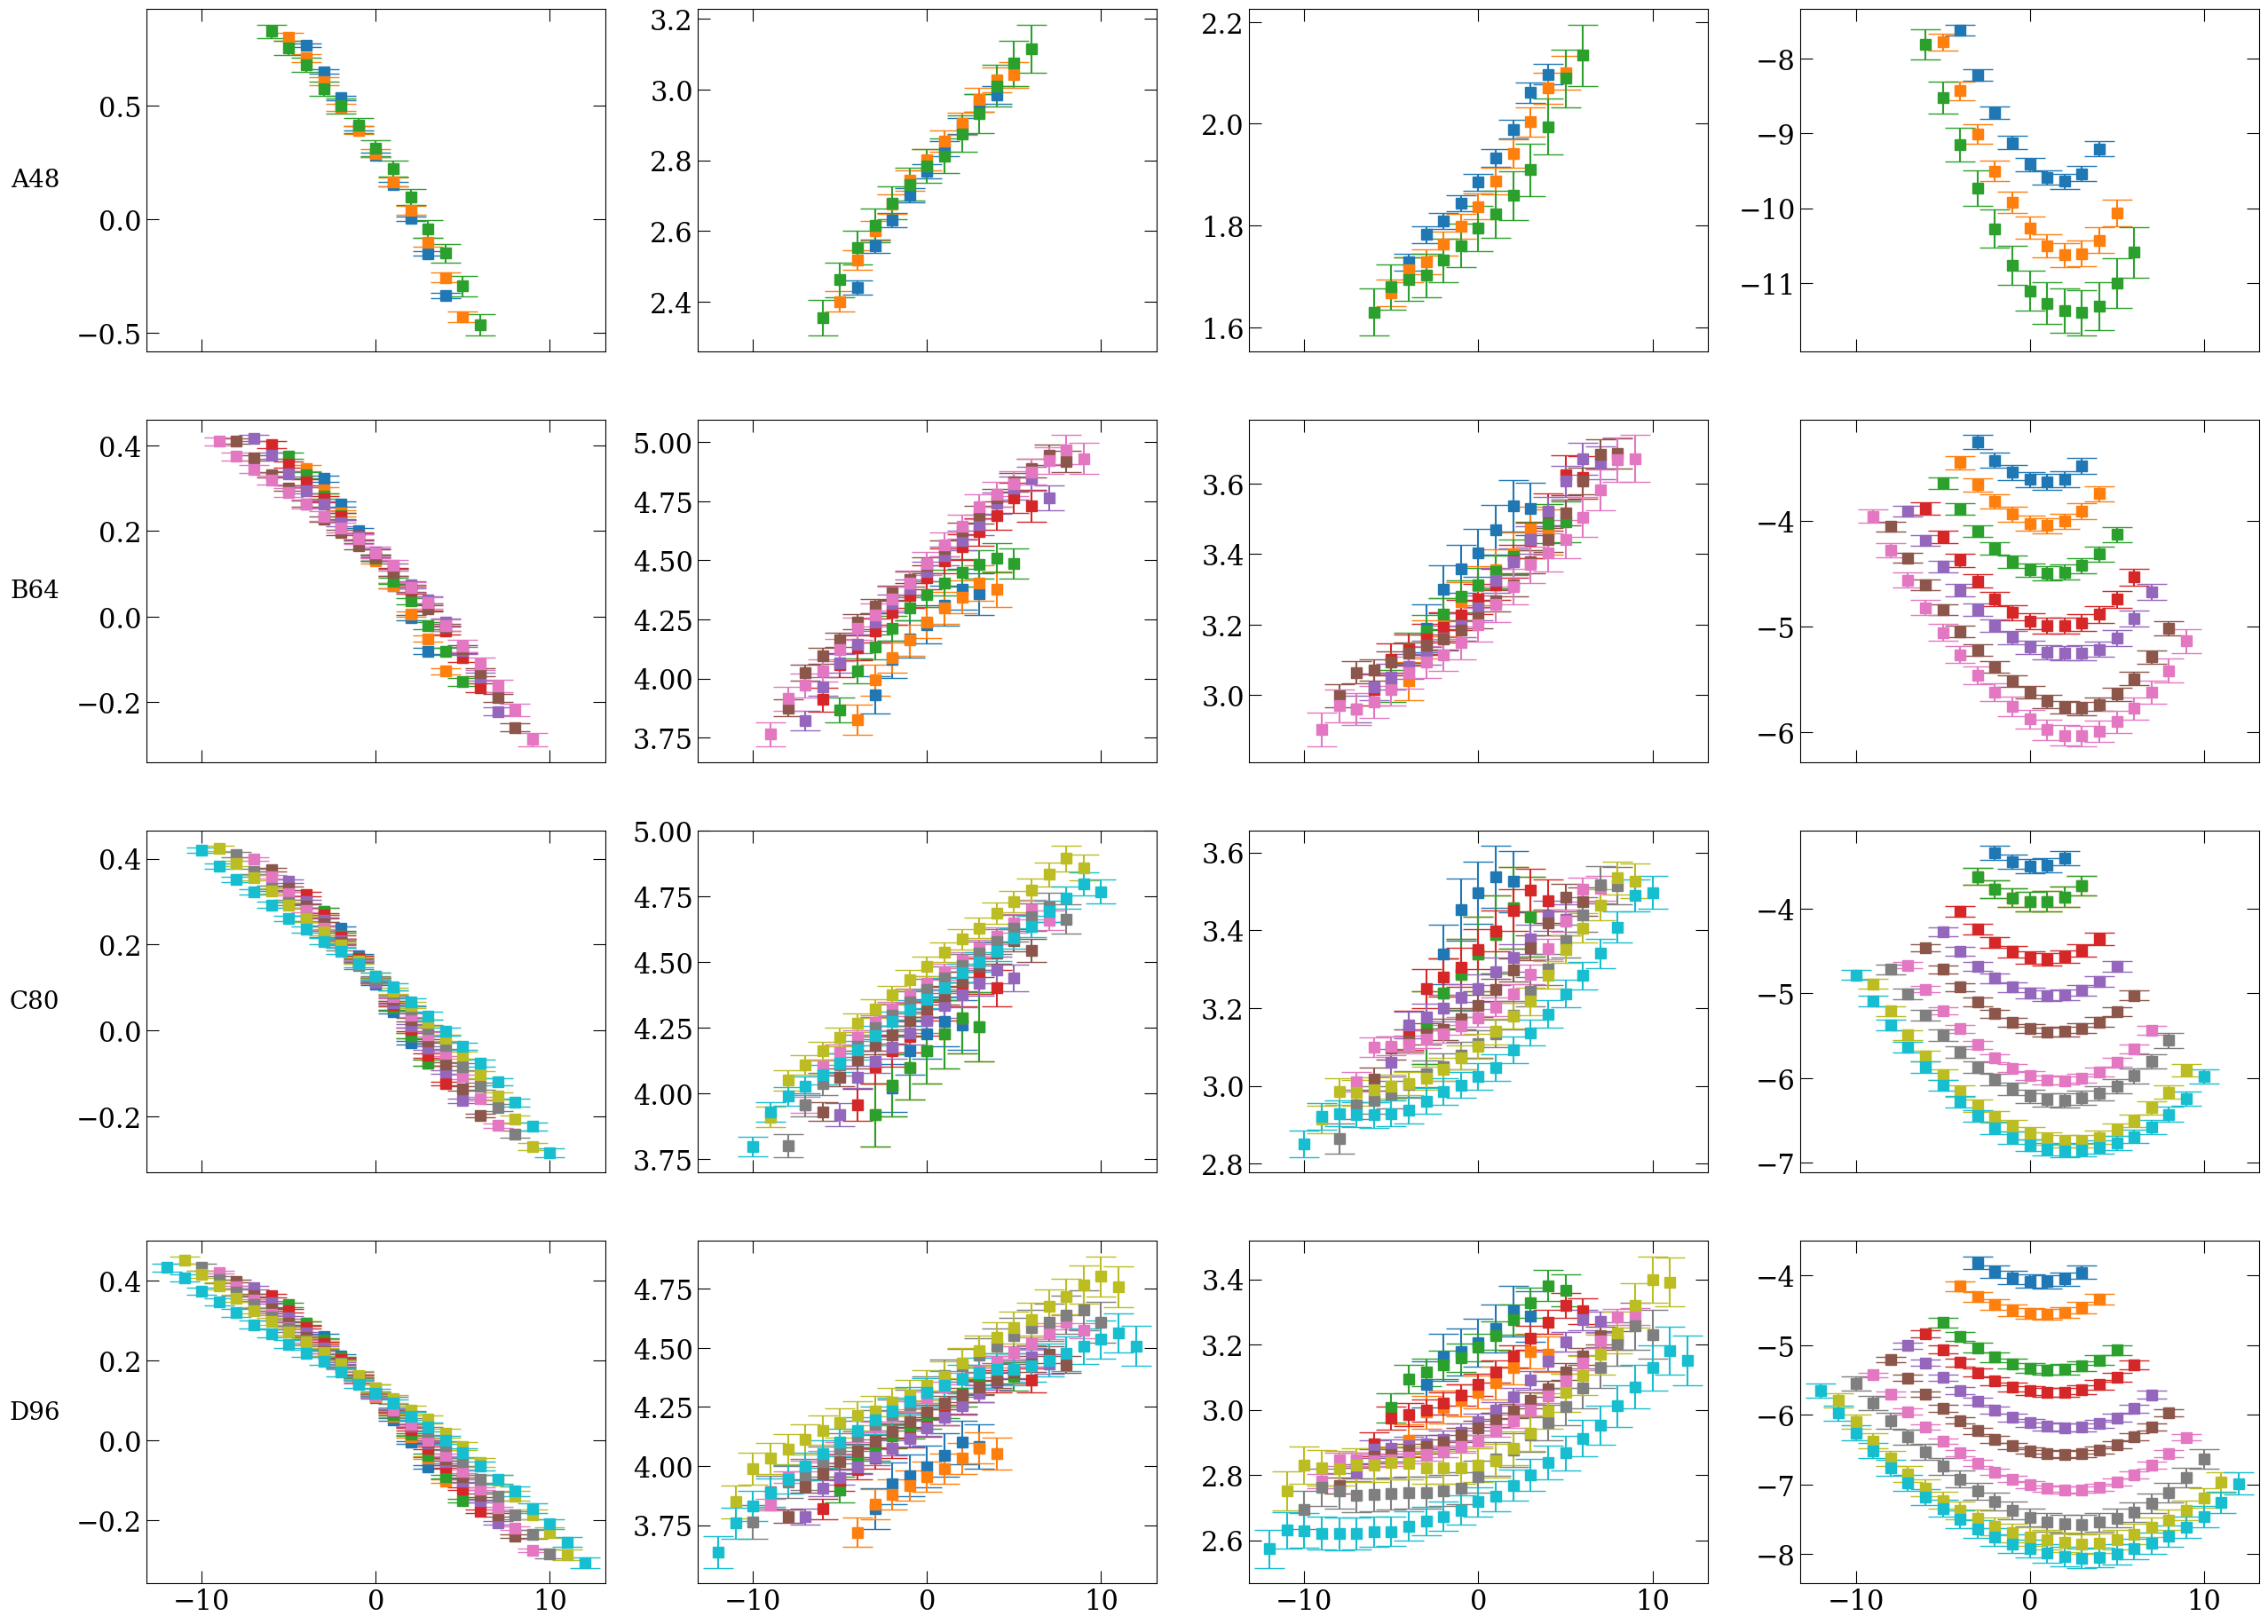

In [5]:
kys=['G0_mom1','GA_mom1_momi0','GA_mom1_momi1','G5_mom1']

fig, axs = yu.getFigAxs(len(enss),len(kys),sharex=True)
yu.addRowHeader(axs,[ens2label[ens] for ens in enss],fontsize=20)
xunit=1; yunit=1

for iens,ens in enumerate(enss):
    irow=iens
    data=datas[ens]
    for i_ky,ky in enumerate(kys):
        ax=axs[irow,i_ky]

        c2pta=yu.jackknife(data['twop_mom0'])
        c2ptb=yu.jackknife(data['twop_mom1'])

        tfs=[int(tf[2:]) for tf in data[ky].keys()]
        tfs.sort()

        for tf in tfs:
            c3pt=yu.jackknife(data[ky][f'dt{tf}'])
            ratio=c3pt/np.sqrt(c2pta[:,tf:tf+1]*c2ptb[:,tf:tf+1]) *\
                c2pta[:,:tf+1]/c2pta[:,:tf+1][:,::-1]*c2ptb[:,:tf+1][:,::-1]/c2ptb[:,:tf+1]
                
            mean,err=yu.jackme(ratio)
            plt_x=np.arange(1 - tf//2,tf//2)*xunit; plt_y=mean[1:tf]*yunit; plt_yerr=err[1:tf]*yunit
            ax.errorbar(plt_x,plt_y,plt_yerr)  
        